# Melanoma Classification


 # Janaki Sajja


What is Melanoma?
* Melanoma is a serious form of skin cancer that begins in cells known as melanocytes. While it is less common than basal cell carcinoma (BCC) and squamous cell carcinoma (SCC), melanoma is more dangerous because of its ability to spread to other organs more rapidly if it is not treated at an early stage.

What does early signs of melanoma look like?
* Melanoma borders tend to be uneven and may have scalloped or notched edges, while common moles tend to have smoother, more even borders. C is for Color. Multiple colors are a warning sign. While benign moles are usually a single shade of brown, a melanoma may have different shades of brown, tan or black.

Benign Tumors
* Benign tumors are normal cells that divide and grow too much, but do not interfere with the function of normal cells around them. They do not have the ability to move from where they originated. They are not cancerous and usually do not become cancerous, no matter how large they grow. Benign tumors frequently stop growing once they reach a certain size and do not invade other tissues. When benign tumors are removed, they usually do not grow back (recur) and do not spread to distant parts of the body (metastasize).

Malignant Tumors
* Malignant tumors are overgrowths of abnormal cells (cancer) that divide without control and order. They do not stop growing, even when they come into contact with nearby cells. As malignant tumors grow, they squeeze surrounding healthy tissue and prevent their normal function. They also release certain signals that cause the creation of new blood vessels to feed the tumor.

Images are also provided in JPEG and TFRecord format (in the jpeg and tfrecords directories, respectively). Images in TFRecord format have been resized to a uniform 1024x1024.

Metadata is also provided outside of the DICOM format, in CSV files. See the Columns section for a description.

We are predicting a binary target for each image. Our model is predicting the probability between 0.0 and 1.0 that the lesion in the image is malignant. In the training data, train.csv, the value 0 denotes benign, and 1 indicates malignant.

Files
* train.csv - the training set
* test.csv - the test set
* sample_submission.csv - a sample submission file in the correct format

Columns
* image_name - unique identifier, points to filename of related DICOM image
* patient_id - unique patient identifier
* sex - the sex of the patient (when unknown, will be blank)
* age_approx - approximate patient age at time of imaging
* anatom_site_general_challenge - location of imaged site
* diagnosis - detailed diagnosis information (train only)
* benign_malignant - indicator of malignancy of imaged lesion
* target - binarized version of the target variable

#### Dataset Information
* The dataset consists of images in:
    * DIOCOM format
    * JPEG format in JPEG directory
    * TFRecord format in tfrecords directory
* For most of the patients we only have a few images ranging fom 1 to roughly 20.
* More than 45 images per patient is very seldom! Nonetheless we have patients with more than 100 images.
* There is one heavy outlier patient in the test set with close to 250 images.
* We have more malignant cases of higher age than benign cases. 62 % of the malignant cases belong to males and only 38 % to females

In [1]:
!pip install -q efficientnet

# **Importing Necessary Libraries**

In [2]:
import os
import re
import seaborn as sns
import numpy as np
import pandas as pd
import math

from matplotlib import pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.layers as L

import efficientnet.tfkeras as efn

from kaggle_datasets import KaggleDatasets

# **Setting Up TPU**

In [9]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

# **Importing Data**

In [5]:
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

# Data access
GCS_PATH = KaggleDatasets().get_gcs_path('siim-isic-melanoma-classification')

In [10]:
EPOCHS = 12
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
IMAGE_SIZE = [1024, 1024]

In [11]:
def append_path(pre):
    return np.vectorize(lambda file: os.path.join(GCS_DS_PATH, pre, file))

In [12]:
sub = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv')
train = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/train.csv')

# **Exploratory Data Analysis**

The no.of male patient Ids are more than the female patient ids in the train data set

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Sex')]

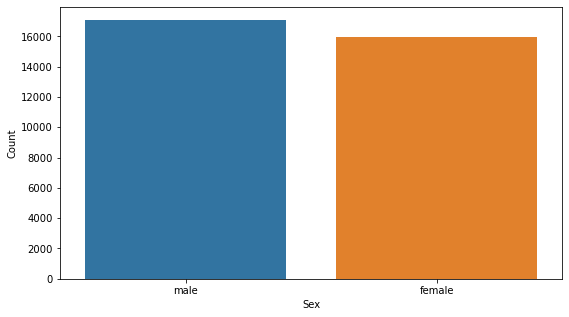

In [13]:
plt.figure(figsize=(9,5))
gender = sns.countplot(train['sex'])
gender.set(xlabel='Sex',ylabel='Count')

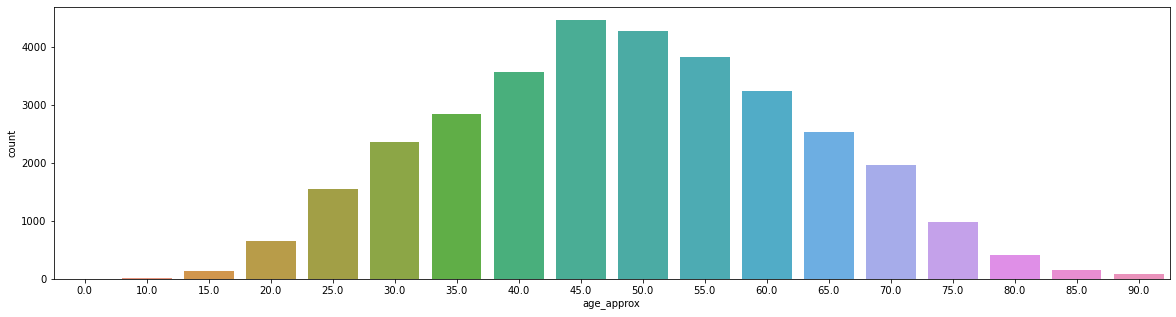

In [14]:
plt.figure(figsize=(20,5))
sns.countplot(train['age_approx'])

The graphs show that the people of age group 45-50 are mostly diagnosed by melanoma cancer. People of age group 15-20 and 85-90 are least prone to melanoma cancer.

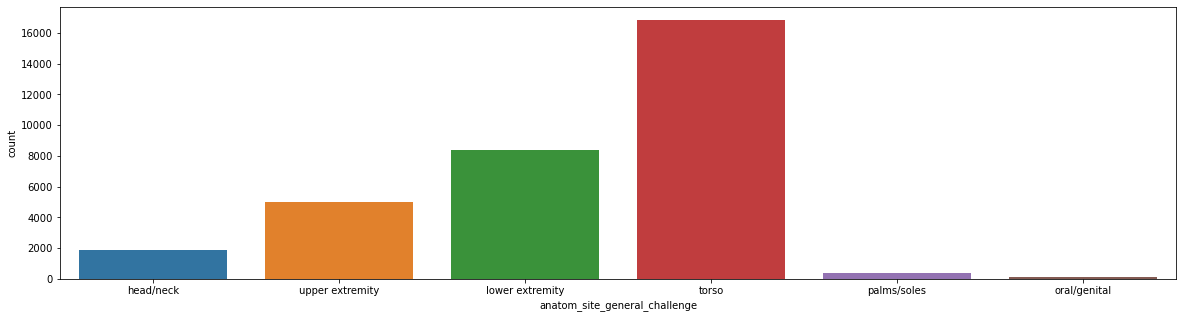

In [15]:
plt.figure(figsize=(20,5))
sns.countplot(train['anatom_site_general_challenge'])

Most of the patients are diagonised at torso area, followed by lower extremity. Least no.of patients are diagonised at palms/soles and oral/genital areas

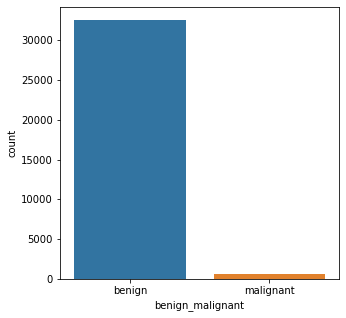

In [16]:
plt.figure(figsize=(5,5))
sns.countplot(train['benign_malignant'])

More people are diagonised with beningn and very least of malignant cases are there in the dataset.

Target == 0 resembles benign and target == 1 resembles malignant in the dataset

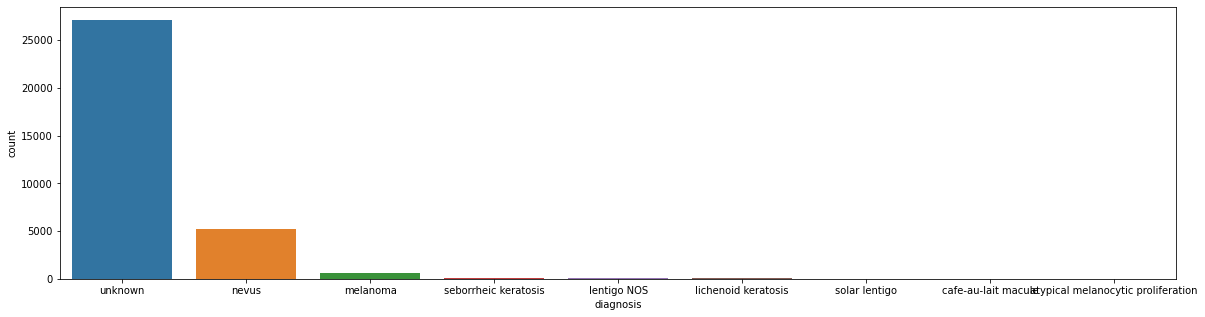

In [17]:
plt.figure(figsize=(20,5))
sns.countplot(train['diagnosis'])

the diagnosis is unknown for most of the cases

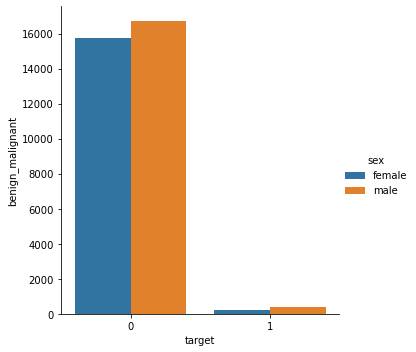

In [18]:
targetvxgender = train.groupby(['sex','target']).count()['benign_malignant'].to_frame().reset_index()
sns.catplot(x='target', y='benign_malignant',hue='sex', data = targetvxgender,kind='bar')

Female are less effected by both malignant and benign when compared to male

Text(0.5, 21.70625000000002, 'anatom_site_general_challenge')

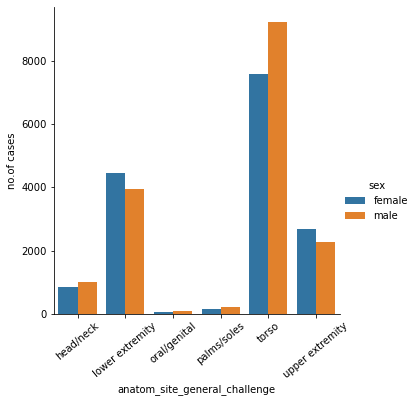

In [19]:
imagevsgender = train.groupby(['sex','anatom_site_general_challenge']).count()['benign_malignant'].to_frame().reset_index()
sns.catplot(x='anatom_site_general_challenge',y='benign_malignant', hue='sex',data=imagevsgender,kind='bar')
plt.ylabel('no.of cases')
plt.xticks(rotation=40)
plt.xlabel('anatom_site_general_challenge')

Both men and women were highly diagonised in torso area and least at oral/genital and palms/shoes region.

# **Data Preprocessing**

### Data Preparation for TPU

In the cell below, we are taking the path of training and testing tfrec files to TRAINING_FILENAMES, TEST_FILENAMES respectively.

In [20]:
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/tfrecords/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/tfrecords/test*.tfrec')

CLASSES = [0,1]   

### **Different Functions For TPU Read**

In the cell below, we have written several functions for TPU read. 
* image_preprocessing : This function reads the image and creates a matrix and then the image matrix is converted into float and then it is reshaped. 
* read_labeled_tfrecord : This function read the data from all the labeled tfrecord files and outputs the image and its label.
* read_unlabeled_tfrecord : This function read the data from all the unlabeled tfrecord files and outputs the image and creates a new label id.
* load_dataset : This function load the dataset from the various .tfrec files
* data_augmentation : Data Augmentation increases the data availablity to the model by perform cropping, padding, horizontal fliping, etc. Here in our function we are fliping the image.
* get_training_dataset : This function fetches all the training data and creates a dataset.
* get_validation_dataset : This function fetches all the validation data and creates a dataset.
* get_test_dataset : This function fetches all the test data and creates the dataset.
* count_data_items : This function counts the number of items in the dataset.


Then below variables are calculated.
* number_of_training_images is calculated by counting the TRAINING_FILENAMES
* number_of_test_images is calculated by counting the TEST_FILENAMES
* steps_per_epoch is calculated using this foumula: number_of_training_images // BATCH_SIZE

In [22]:
def image_preprocessing(image_data): #Reads the image and creates a matrix and then the image matrix is converted into float and then it is reshaped
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) 
    return image

def read_labeled_tfrecord(example): #Read the data from all the labeled tfrecord files and outputs the image and its label
    labeled_tfrec_format = {
        "image": tf.io.FixedLenFeature([], tf.string), 
        "target": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, labeled_tfrec_format)
    image = image_preprocessing(example['image'])
    label = tf.cast(example['target'], tf.int32)
    return image, label

def read_unlabeled_tfrecord(example): #Read the data from all the unlabeled tfrecord files and outputs the image and creates a new label id. 
    unlabeled_tfrec_format = {
        "image": tf.io.FixedLenFeature([], tf.string), 
        "image_name": tf.io.FixedLenFeature([], tf.string),  
    }
    example = tf.io.parse_single_example(example, unlabeled_tfrec_format)
    image = image_preprocessing(example['image'])
    idnum = example['image_name']
    return image, idnum

def load_dataset(filenames, labeled=True, ordered=False): #Load the dataset from the various .tfrec files
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) 
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    return dataset

def data_augmentation(image, label): #Data Augmentation increases the data availablity to the model by perform cropping, padding, horizontal fliping, etc. Here in our function we are fliping the image
    image = tf.image.random_flip_left_right(image)
    return image, label   

def get_training_dataset(): #Fetches all the training data and creates a dataset
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augmentation, num_parallel_calls=AUTO)
    dataset = dataset.repeat() 
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_validation_dataset(ordered=False): #Fetches all the validation data and creates a dataset
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered=False): #Fetches all the test data and creates the dataset
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames): #Function to count the number of items in the dataset
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

number_of_training_images = count_data_items(TRAINING_FILENAMES)
number_of_test_images = count_data_items(TEST_FILENAMES)
steps_per_epoch = number_of_training_images // BATCH_SIZE
print(f'Dataset: {number_of_training_images} training images, {number_of_test_images} unlabeled test images')

Dataset: 33126 training images, 10982 unlabeled test images


### **Function For Variable Learning Rate**

The below function is used for variable learning rate. As the model gets trained the learning rate decreases.

In [23]:
def build_lrfn(lr_start=0.00001, lr_max=0.0001, 
               lr_min=0.000001, lr_rampup_epochs=20, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    
    return lrfn

# **Model Preparation**

In below cell, we are defining a sequential model with efficientNetB7 (Tensorflow keras)
The Sequential model in keras is actually one of the simplest neural networks, a multi-layer perceptron. 
Here we are using this model to because a Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor. 
We have total 5 layers in our model. We have created a Sequential model by passing a list of layers to the Sequential constructor. Please follow the below images to understand it better.
Generally all the layers in keras need to know the shape of their inputs in order to be able to create therir weights. 
* We have specified input shape as (*IMAGE_SIZE variable, 3). 
* We have used ‘relu’ activation for 4 layeres and ‘sigmoid’ activation for 5th. In our model, no. of units we started with first layer as 1024 and decreased them gradually till 1. 
* Generally, use a small dropout value of 20%-50% of neurons with 20% providing a good starting point. A probability too low has minimal effect and a value too high results in under-learning by the network. Use dropout on visible as well as hidden units. Application of dropout at each layer of the network has shown good results.

After creating our model, we are compiling it. And printing model summary.


In [24]:
with strategy.scope():
    model = tf.keras.Sequential([
        efn.EfficientNetB7(
            input_shape=(*IMAGE_SIZE, 3),
            weights='imagenet',
            include_top=False
        ),
        L.GlobalAveragePooling2D(),
        L.Dense(1024, activation = 'relu'), 
        L.Dropout(0.3), 
        L.Dense(512, activation= 'relu'), 
        L.Dropout(0.2), 
        L.Dense(256, activation='relu'), 
        L.Dropout(0.2), 
        L.Dense(128, activation='relu'), 
        L.Dropout(0.1), 
        L.Dense(1, activation='sigmoid')
    ])
    
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.1),
    metrics=['binary_crossentropy','accuracy']
)
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 32, 32, 2560)      64097680  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2560)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              2622464   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)              

In cell below, we are calculating learning rate, and using learning rate scheduler. At the beginning of every epoch, this callback gets the updated learning rate value from schedule function provided at __init__, with the current epoch and current learning rate, and applies the updated learning rate on the optimizer.
We are calculating steps_per_epoch using this formula: number_of_training_images // BATCH_SIZE

In [26]:
lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

steps_per_epoch = number_of_training_images // BATCH_SIZE

# **Model Fitting**

In [27]:
history = model.fit(
    get_training_dataset(), 
    epochs=6, 
    callbacks=[lr_schedule],
    steps_per_epoch=steps_per_epoch
)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/6
517/517 [==============================] - 974s 2s/step - accuracy: 0.9788 - loss: 0.3124 - binary_crossentropy: 0.2036 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 4.95e-05.
Epoch 2/6
517/517 [==============================] - 975s 2s/step - accuracy: 0.9821 - loss: 0.2470 - binary_crossentropy: 0.1159 - lr: 4.9500e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 8.9e-05.
Epoch 3/6
517/517 [==============================] - 975s 2s/step - accuracy: 0.9824 - loss: 0.2434 - binary_crossentropy: 0.1105 - lr: 8.9000e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0001285.
Epoch 4/6
517/517 [==============================] - 975s 2s/step - accuracy: 0.9827 - loss: 0.2417 - binary_crossentropy: 0.1082 - lr: 1.2850e-04

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000168.
Epoch 5/6
517/517 [==============================] - 97

# **Making predictions using trained model**

In the cell below, we are trying to predict the binary target for images from test dataset. Our model is predicting the probability between 0.0 and 1.0 that the lesion in the image is malignant or not.

In [28]:
test_dataset = get_test_dataset(ordered=True)
test_images_dataset = test_dataset.map(lambda image, idnum: image)
probabilities = model.predict(test_images_dataset)

In [30]:
test_ids_dataset = test_dataset.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_dataset.batch(number_of_test_images))).numpy().astype('U')

In [31]:
pred_df = pd.DataFrame({'image_name': test_ids, 'target': np.concatenate(probabilities)})
pred_df.head()

,image_name,target
0,ISIC_6381819,0.207136
1,ISIC_5583376,0.096270
2,ISIC_6408546,0.073663
3,ISIC_6932354,0.089517
4,ISIC_8191278,0.137625


In the training data, train.csv, the value 0 denotes benign, and 1 indicates malignant.
Below image shows, the actual value in test dataset. Which means those images are benign.

In [32]:
sub.head()


,image_name,target
0,ISIC_0052060,0
1,ISIC_0052349,0
2,ISIC_0058510,0
3,ISIC_0073313,0
4,ISIC_0073502,0


And the image given below has predicted values from test dataset, test.csv, where target is near 0.
Which means all the 5 images are benign, and our prediction is accurate.

In [34]:
del sub['target']
sub = sub.merge(pred_df, on='image_name')
sub.to_csv('new_submission.csv', index=False)
sub.head()

,image_name,target
0,ISIC_0052060,0.082039
1,ISIC_0052349,0.095533
2,ISIC_0058510,0.081146
3,ISIC_0073313,0.102881
4,ISIC_0073502,0.128931
